# Transient Heat Conduction in Various Geometries

Transport of heat in a solid is described by the familiar thermal diffusion model

\begin{align*}
\rho C_p\frac{\partial T}{\partial t} & = \nabla\cdot(k\nabla T)
\end{align*}

### Rescaling

We'll assume the thermal conductivity $k$ is a constant, and define thermal diffusivity in the conventional way

\begin{align*}
\alpha & = \frac{k}{\rho C_p}
\end{align*}

We will further assume symmetry with respect to all spatial coordinates except $r$ where $r$ extends from $-R$ to $+R$. The boundary conditions are

\begin{align*}
T(t,R) & = T_{\infty} & \forall t > 0 \\
\nabla T(t,0) & = 0 & \forall t \geq 0 
\end{align*}

where we have assumed symmetry with respect to $r$ and uniform initial conditions $T(0, r) = T_0$ for all $0 \leq r \leq R$. Following standard scaling procedures, we introduce the dimensionless variables

\begin{align*}
T' & = \frac{T - T_0}{T_\infty - T_0} \\
r' & = \frac{r}{R} \\
t' & = t \frac{\alpha}{R^2}
\end{align*}

### Dimensionless Model

Under these conditions the problem reduces to 

\begin{align*}
\frac{\partial T'}{\partial t'} & = \nabla^2 T'
\end{align*}

with auxiliary conditions

\begin{align*}
T'(0, r') & = 0 & \forall 0 \leq r' \leq 1\\
T'(t', 1) & = 1 & \forall t' > 0\\
\nabla T'(t', 0) & = 0 & \forall t' \geq 0 \\
\end{align*}

which we can specialize to specific geometries.

## Preliminary Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

def model_plot(m):
    r = sorted(m.r)
    t = sorted(m.t)

    rgrid = np.zeros((len(t), len(r)))
    tgrid = np.zeros((len(t), len(r)))
    Tgrid = np.zeros((len(t), len(r)))

    for i in range(0, len(t)):
        for j in range(0, len(r)):
            rgrid[i,j] = r[j]
            tgrid[i,j] = t[i]
            Tgrid[i,j] = m.T[t[i], r[j]].value

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('Distance r')
    ax.set_ylabel('Time t')
    ax.set_zlabel('Temperature T')
    p = ax.plot_wireframe(rgrid, tgrid, Tgrid)

## Planar Coordinates

Suppressing the prime notation, for a slab geometry the model specializes to 

\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial r^2}
\end{align*}

with auxiliary conditions

\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1 \\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}

    solver failure.
Academic license - for non-commercial use only
Optimize a model with 10201 rows, 10300 columns and 30348 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 10201 rows and 10300 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   0.000000e+00   1.000000e-04      0s

Solved with dual simplex
Solved in 0 iterations and 0.04 seconds
Optimal objective  1.000000000e+00
Freed default Gurobi environment


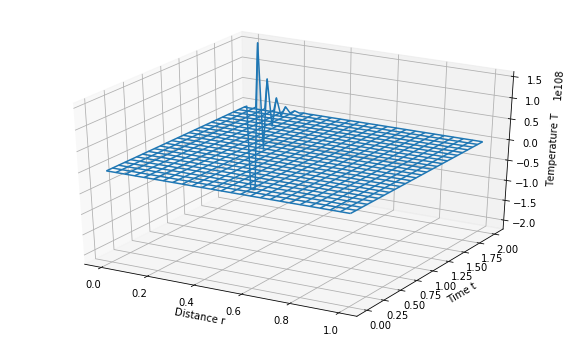

In [9]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,2))

m.T = Var(m.t, m.r)

m.dTdt   = DerivativeVar(m.T, wrt=m.t)
m.dTdr   = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))

@m.Constraint(m.t, m.r)
def pde(m, t, r):
    if t == 0:
        return Constraint.Skip
    if r == 0 or r == 1:
        return Constraint.Skip
    return m.dTdt[t,r] == m.d2Tdr2[t,r]

m.obj = Objective(expr=1)

m.ic  = Constraint(m.r, rule=lambda m, r:    m.T[0,r] == 0 if r > 0 and r < 1 else Constraint.Skip)
m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,1] == 1)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, scheme='FORWARD', wrt=m.r)
TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, scheme='FORWARD', wrt=m.t)
#SolverFactory('ipopt').solve(m, tee=True).write()
SolverFactory('gurobi', executable='/usr/local/bin/gurobi.sh').solve(m, tee=True)
model_plot(m)

## Cylindrical Coordinates

Suppressing the prime notation, for a cylindrical geometry the model specializes to 

\begin{align*}
\frac{\partial T}{\partial t} & = \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial T}{\partial r}\right)
\end{align*}

Expanding,

\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial t^2} + \frac{1}{r}\frac{\partial T}{\partial r}
\end{align*}

with auxiliary conditions

\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1\\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4060
  Number of variables: 4110
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.2107410430908203
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


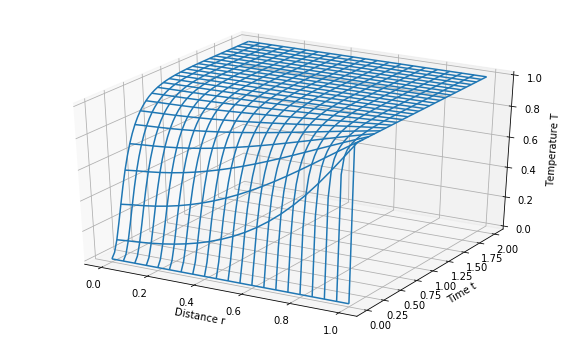

In [3]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,2))

m.T = Var(m.t, m.r)

m.dTdt   = DerivativeVar(m.T, wrt=m.t)
m.dTdr   = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))

m.pde = Constraint(m.t, m.r, rule=lambda m, t, r: m.dTdt[t,r] == m.d2Tdr2[t,r] + (1/r)*m.dTdr[t,r]
        if r > 0 and r < 1 and t > 0 else Constraint.Skip)

m.ic  = Constraint(m.r, rule=lambda m, r:    m.T[0,r] == 0)
m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.r, scheme='CENTRAL')
TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, wrt=m.t, scheme='BACKWARD')
SolverFactory('ipopt').solve(m).write()

model_plot(m)

## Spherical Coordinates

Suppressing the prime notation, for a cylindrical geometry the model specializes to 

\begin{align*}
\frac{\partial T}{\partial t} & = \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2\frac{\partial T}{\partial r}\right)
\end{align*}

Expanding,

\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial t^2} + \frac{2}{r}\frac{\partial T}{\partial r}
\end{align*}

with auxiliary conditions

\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1\\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4060
  Number of variables: 4110
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.19963693618774414
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


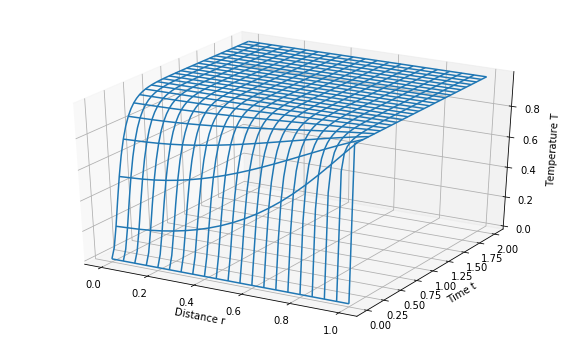

In [4]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,2))

m.T = Var(m.t, m.r)

m.dTdt   = DerivativeVar(m.T, wrt=m.t)
m.dTdr   = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))

m.pde = Constraint(m.t, m.r, rule=lambda m, t, r: m.dTdt[t,r] == m.d2Tdr2[t,r] + (2/r)*m.dTdr[t,r]
        if r > 0 and r < 1 and t > 0 else Constraint.Skip)

m.ic  = Constraint(m.r, rule=lambda m, r:    m.T[0,r] == 0)
m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.r, scheme='CENTRAL')
TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, wrt=m.t, scheme='BACKWARD')
SolverFactory('ipopt').solve(m).write()

model_plot(m)